In [2]:
import numpy as np
from scipy import signal
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import pycbc.waveform
from pycbc.waveform import get_td_waveform
from pycbc.waveform import get_fd_waveform
from pycbc.psd import estimate
from pycbc.types import TimeSeries
import emcee
import corner
import time
from multiprocessing import Pool
from multiprocessing import cpu_count
import scipy

# In the cell i am sorting the data to windowing and making psd

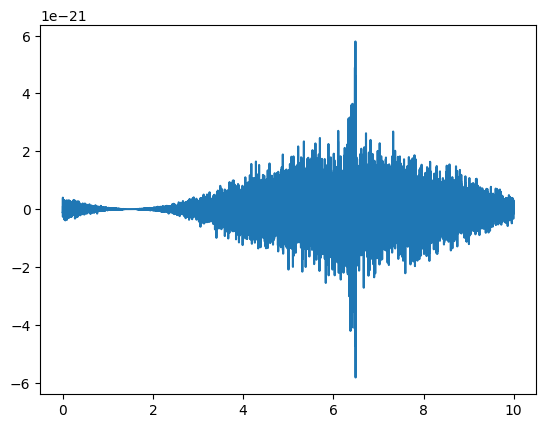

/Users/maxrobertson/code/Grav Waves/venv/lib/python3.9/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/maxrobertson/code/Grav Waves/venv/lib/python3.9/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


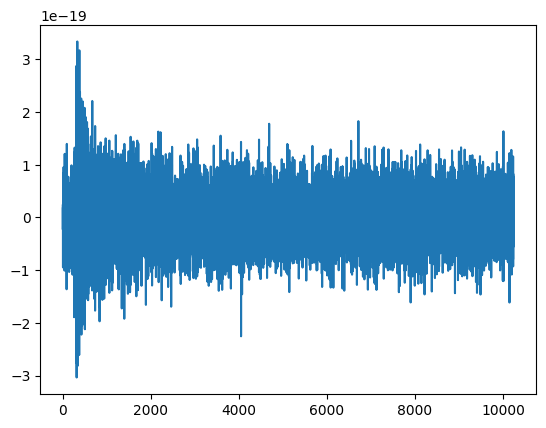

In [3]:
# loading in data 
time_data, strain_data = np.loadtxt('data/PE_unknown_white_data_ts.txt',skiprows = 1).T
time_noise, strain_noise = np.loadtxt('data/PE_unknown_white_noise_ts.txt',skiprows=1).T


# converting to time series
strain_noise_ts = TimeSeries(strain_noise, delta_t = time_noise[1]-time_noise[0])
strain_data_ts = TimeSeries(strain_data,delta_t=time_data[1]-time_data[0])


# rolling to the middle and windowing and rolling back to 8 seconds
mid_point = len(strain_data) /2
final_point = len(strain_data)
peaks,_ = find_peaks(strain_data,height = 3e-21,distance = 1000)
roll_amount = mid_point - peaks
centred = np.roll(strain_data,int(roll_amount))
delta_t = time_data[1] - time_data[0]
window = signal.windows.hann(len(centred))
centred_windowed_signal = centred*window
centred_windowed_signal_final = np.roll(centred_windowed_signal,-int(roll_amount))
plt.plot(time_data,centred_windowed_signal_final)
plt.show()
#defining main data and shaping
data_freq = np.fft.rfft(centred_windowed_signal_final) 
freq_array = np.fft.rfftfreq(len(time_data),delta_t)
plt.plot(data_freq)
delta_f = freq_array[1]-freq_array[0]

high_cutoff = 1000
low_cutoff = 30

high_limit = 1000/delta_f+1
low_limit = 30/delta_f

data_final = data_freq[:int(high_limit)]
freq_final = freq_array[:int(high_limit)]

data_final[freq_final < low_cutoff] = 0 

#defing psd
delta_t = time_data[1] - time_data[0]
duration = len(strain_data)*delta_t
seg_len = len(strain_noise_ts) // 4
seg_stride = seg_len // 2

psd = estimate.welch(strain_noise_ts,window = 'hann' ,seg_len=seg_len,seg_stride = seg_stride)
psd_freqs = np.fft.fftfreq(len(psd), d=delta_t)  

interp_psd = interp1d(psd_freqs, psd, kind='linear', bounds_error=False, fill_value="extrapolate")
psd_interpolated = interp_psd(freq_array[:int(high_limit)]) 


In [4]:
# plt.plot(time_data,centred_windowed_signal)

In [5]:
# plt.plot(data_final)
# print(len(data_final))

# defining the template

In [6]:
def template(theta,delta_t,f_lower,f_higher,delta_f):
    M1,M2,D,time_shift = theta 

    hplus , hc = get_fd_waveform(mass1 = M1,mass2 = M2,distance = D, approximant='IMRPhenomPv2',f_lower=f_lower, f_higher=f_higher, delta_t = delta_t,delta_f = delta_f)

    hplus= hplus.cyclic_time_shift(time_shift)
    if len(hplus) > len(data_final):
        hplus = hplus[:len(data_final)]
        return hplus
    
    if len(hplus) == len(data_final):
        return hplus
    
    if len(hplus) < len(data_final):
        pad_amount = len(data_final) - len(hplus)
        hplus = np.pad(hplus,(0,pad_amount),'constant',constant_values=(0,0))
        return hplus

[-0.+0.j  0.+0.j -0.+0.j ...  0.+0.j  0.+0.j  0.+0.j]


/Users/maxrobertson/code/Grav Waves/venv/lib/python3.9/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/maxrobertson/code/Grav Waves/venv/lib/python3.9/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


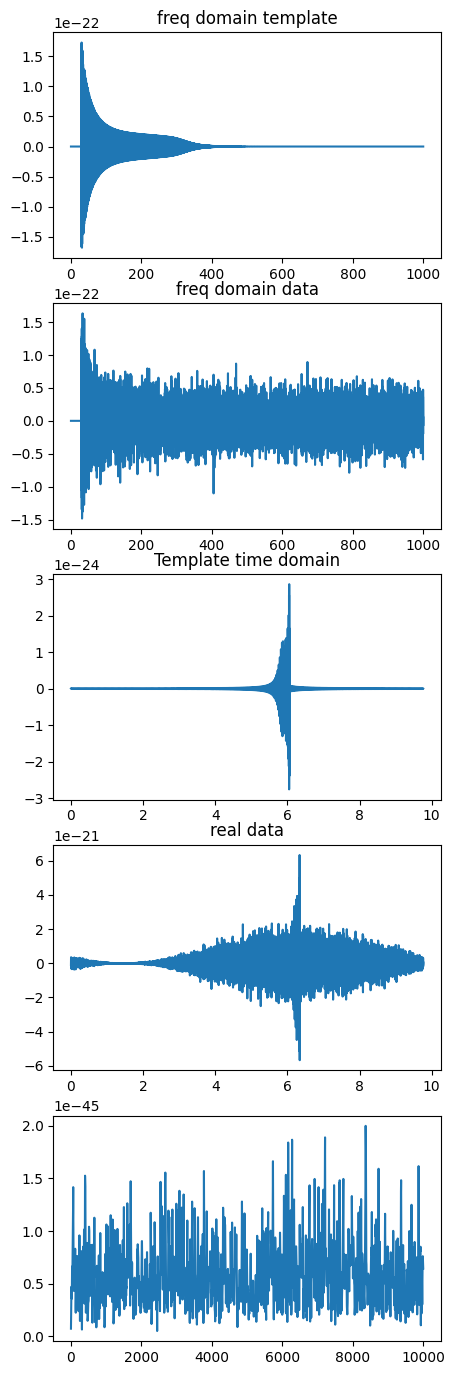

In [7]:
theta = 35,20,100,6.2
temp = template(theta,delta_t,30,1000,delta_f)#0.00873
print(temp)
plt.figure(figsize = (5,17))
plt.subplot(511)
plt.plot(freq_final,temp)
plt.title('freq domain template')

plt.subplot(512)
plt.plot(freq_final, data_final*delta_t)
plt.title('freq domain data')

plt.subplot(513)
plt.plot(time_data[:20000],np.fft.irfft(temp))
plt.title('Template time domain')

plt.subplot(514)
plt.plot(time_data[:20000],np.fft.irfft(data_final))
plt.title('real data')

plt.subplot(515)
plt.plot(psd_interpolated)

In [8]:
#

# Defining the prior in log space

In [79]:
def log_prior(theta):
    M1,M2,D,time_shift = theta
    
    if not(36 < M1 < 40):
        return - np.inf
    
    if not(32 < M2 < M1):
        return -np.inf 
    
    if not(150 < D < 170):
        return -np.inf
    
    if not(6.4 < time_shift < 6.6):
        return -np.inf

    # if not(0<f_lower<1000):
    #     return -np.inf
    
    # if not(f_lower<f_higher<4000):
    #     return -np.inf

    # if not (28 < M2 < M1):
    #     return -np.inf
    
    return 0 + 2*np.log(D)



In [73]:
# def log_prior(theta):
#     M1,M2,D,time_shift = theta
    
#     if not(28 < M1 < 34):
#         return - np.inf
    
#     if not(25 < M2 <31):
#         return -np.inf 
    
#     if not(240 < D < 260):
#         return -np.inf
    
#     if not(6.4 < time_shift < 6.6):
#         return -np.inf

#     # if not(0<f_lower<1000):
#     #     return -np.inf
    
#     # if not(f_lower<f_higher<4000):
#     #     return -np.inf
    
#     return 0 + 2*np.log(D)


# Defining the log likelihood function

In [74]:
def log_like(theta, fft_signal,noise ,delta_t,delta_f):

    
    temp = template(theta, delta_t , 30, 1000,delta_f)

    residual = fft_signal*delta_t - temp
    summation = np.abs(residual)**2/noise
    return -2 / duration * sum((summation))

# Defining the log posterior

In [75]:
def log_posterior(theta, data,noise_data,delta_t,delta_f):
    # print(f"Theta: {theta}")
    log_pri = log_prior(theta)
    if np.isinf(log_pri):  # if prior is -inf, return stragiht away
        return log_pri
    return log_pri + log_like(theta, data, noise_data,delta_t,delta_f)

# running the mcmc

In [76]:
# nwalkers = 30
# ndim = 3

# initial = np.empty((nwalkers, ndim)) 
# initial[:, 0] = np.random.uniform(30, 34, size=nwalkers)
# initial[:, 1] = np.random.uniform(28, initial[:, 0])
# initial[:, 2] = np.random.uniform(80, 150, size=nwalkers)

# with Pool() as pool:
#     sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior,args = (data_final,psd_interpolated,delta_t,delta_f), pool=pool)
#     start = time.time()
#     sampler.run_mcmc(initial, 2000, progress=True)
#     sampler.reset()
#     # running the mcmc
#     nsteps = 2000
#     sampler.run_mcmc(initial, nsteps,progress = True)
#     end = time.time()
#     multi_time = end - start


In [ ]:
# defining the number of walkers in the mcmc chain and th number of dimensions (parameters)
nwalkers = 20
ndim = 4

defining intitial array of guess (theta guesses)
initial = np.empty((nwalkers, ndim)) 
initial[:, 0] = np.random.uniform(36,40 , size=nwalkers)
# initial[:, 1] = np.random.uniform(46, 50, size = nwalkers)#initial[:, 0])
initial[:, 1] = np.random.uniform(32, 36,size = nwalkers)
initial[:, 2] = np.random.uniform(150, 160, size=nwalkers)
initial[:,3] = np.random.uniform(6.4,6.6, size = nwalkers)

# initial = np.random.rand(nwalkers, ndim) 
# for row in range(initial.shape[0]):

#     # print(initial30[row])
#     initial[row][0] = np.random.random() * (40-36) + 36
#     initial[row][1] = np.random.random() * (initial[row][0] - 32) +32
#     initial[row][2] = np.random.random() * (170-150) + 150
#     initial[row][3] = np.random.random() * (6.6-6.4) + 6.4
#running the emcee sampelr
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(data_final,psd_interpolated,delta_t,delta_f))#,moves= emcee.moves.StretchMove())

#running the burn - in stage of the mcmc chain to allow the walker tp explore the space
state = sampler.run_mcmc(initial, nsteps = 1500,progress = True)
sampler.reset()
# running the mcmc

nsteps = 1000
sampler.run_mcmc(initial, nsteps,progress = True)

100%|██████████| 1000/1000 [03:26<00:00,  4.83it/s]


State([[ 37.9869392   34.03592793 165.21293137   6.50002188]
 [ 36.16141757  36.02116119 163.39738078   6.49998335]
 [ 37.03273608  35.17490003 164.98953287   6.50000008]
 [ 39.83177939  35.0639463  169.96908039   6.44371264]
 [ 39.98406494  34.50168457 169.57684852   6.44342813]
 [ 37.34408858  32.82986943 167.25513842   6.43370188]
 [ 37.53545344  34.58768237 165.575789     6.49997392]
 [ 38.13886014  33.84297146 168.1296333    6.49996453]
 [ 37.72046773  34.52842695 168.04942533   6.500006  ]
 [ 39.77264291  32.07276589 169.56142148   6.4379286 ]
 [ 39.99738894  34.55024017 169.66798342   6.44356402]
 [ 36.20266236  36.01765681 165.56302813   6.49989612]
 [ 37.90198603  37.78590868 166.61928081   6.47815165]
 [ 37.651543    34.36538323 163.91731914   6.49993953]
 [ 38.40220799  33.45542408 163.84585001   6.50009881]
 [ 36.16328173  36.09796608 167.2952849    6.49993052]
 [ 36.17965331  36.15922902 165.12259084   6.49992425]
 [ 38.17547248  33.84803188 165.74677694   6.50007867]
 [ 3

31 28 250 

38 34 160 

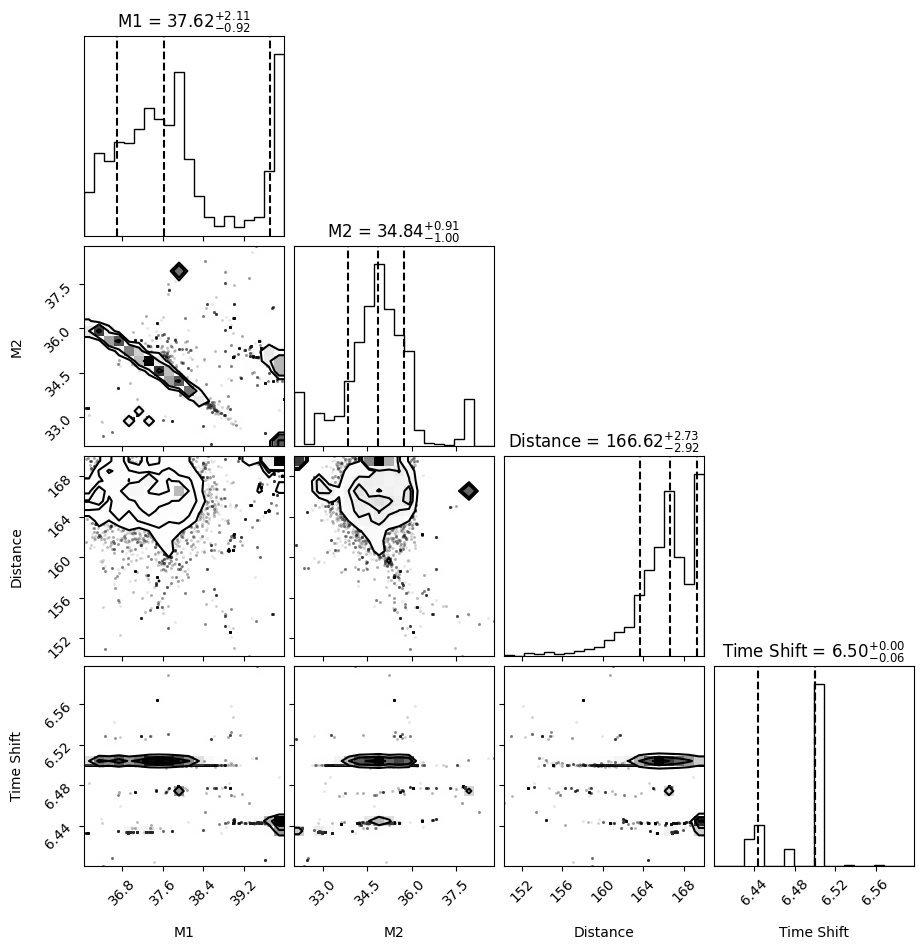

In [ ]:
#main test, delta_t multiplied to signal data

samples = sampler.flatchain

figure = corner.corner(samples,labels = ['M1','M2','Distance','Time Shift'],quantiles=[0.16,0.5,0.84],show_titles = True)

# waterbucket method 



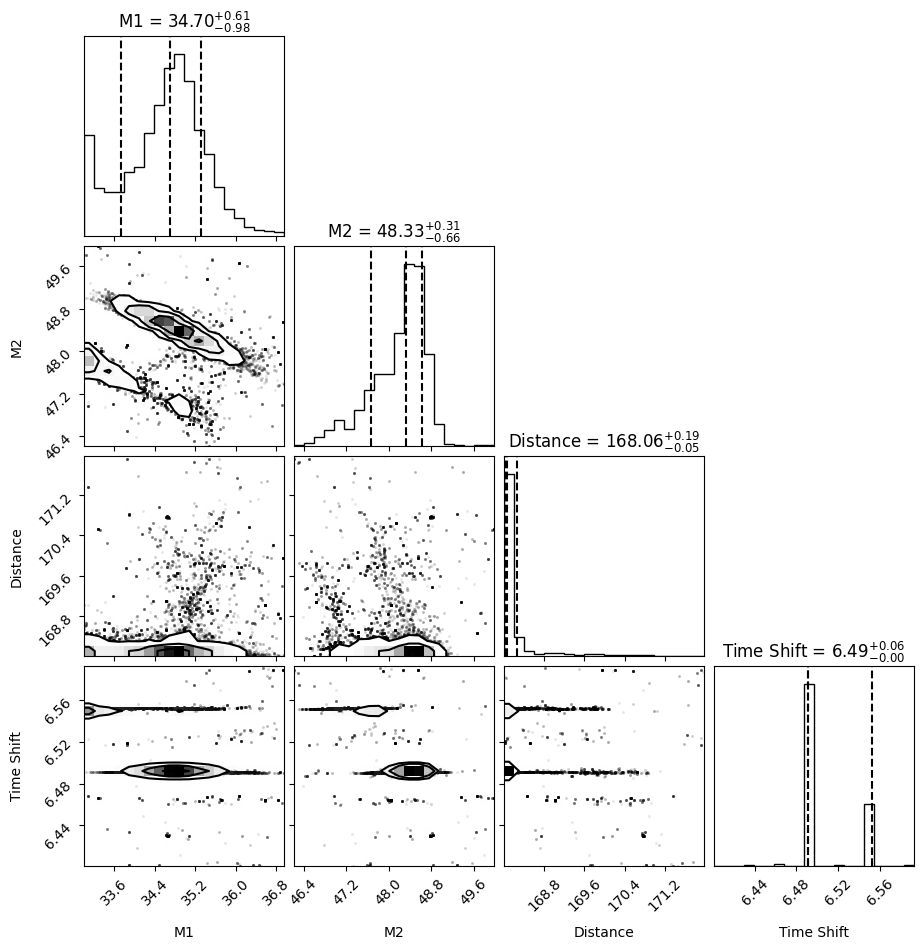

In [ ]:
# this is with delta_t multiplied to template

samples = sampler.flatchain

figure = corner.corner(samples,labels = ['M1','M2','Distance','Time Shift'],quantiles=[0.16,0.5,0.84],show_titles = True)


# figure.savefig("corner_plot_M1_M2_D_time.jpg", format="jpeg", dpi=300)

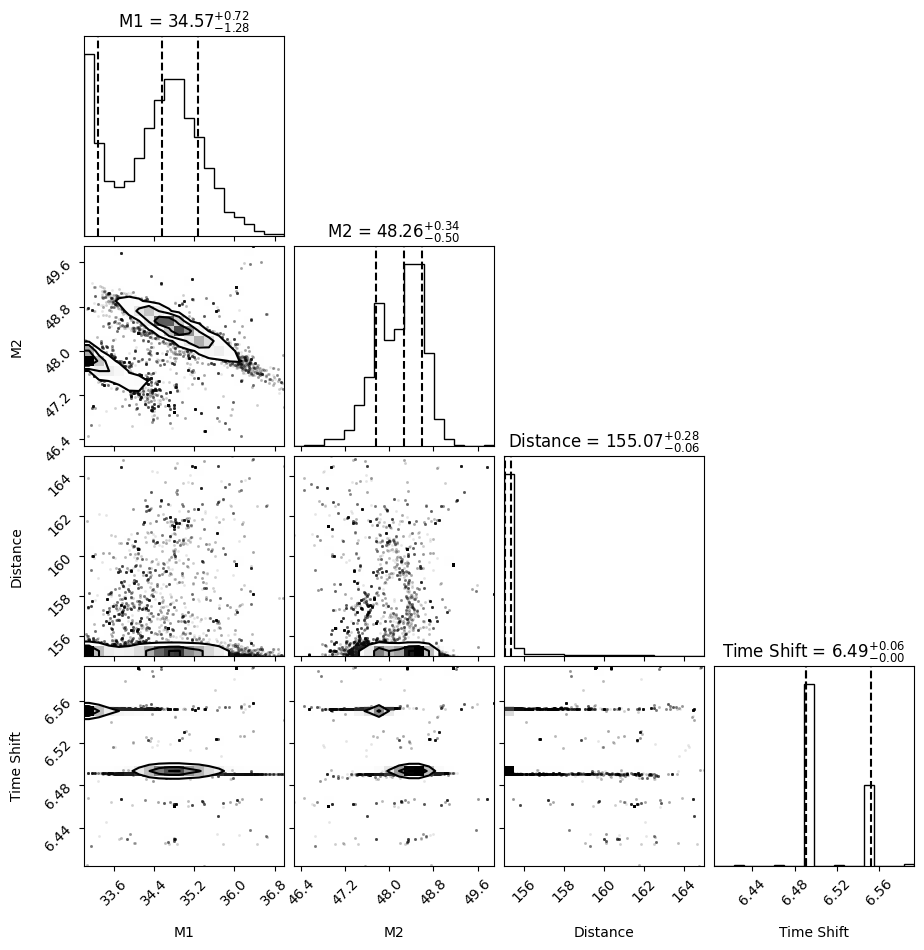

In [45]:

samples = sampler.flatchain

figure = corner.corner(samples,labels = ['M1','M2','Distance','Time Shift'],quantiles=[0.16,0.5,0.84],show_titles = True)

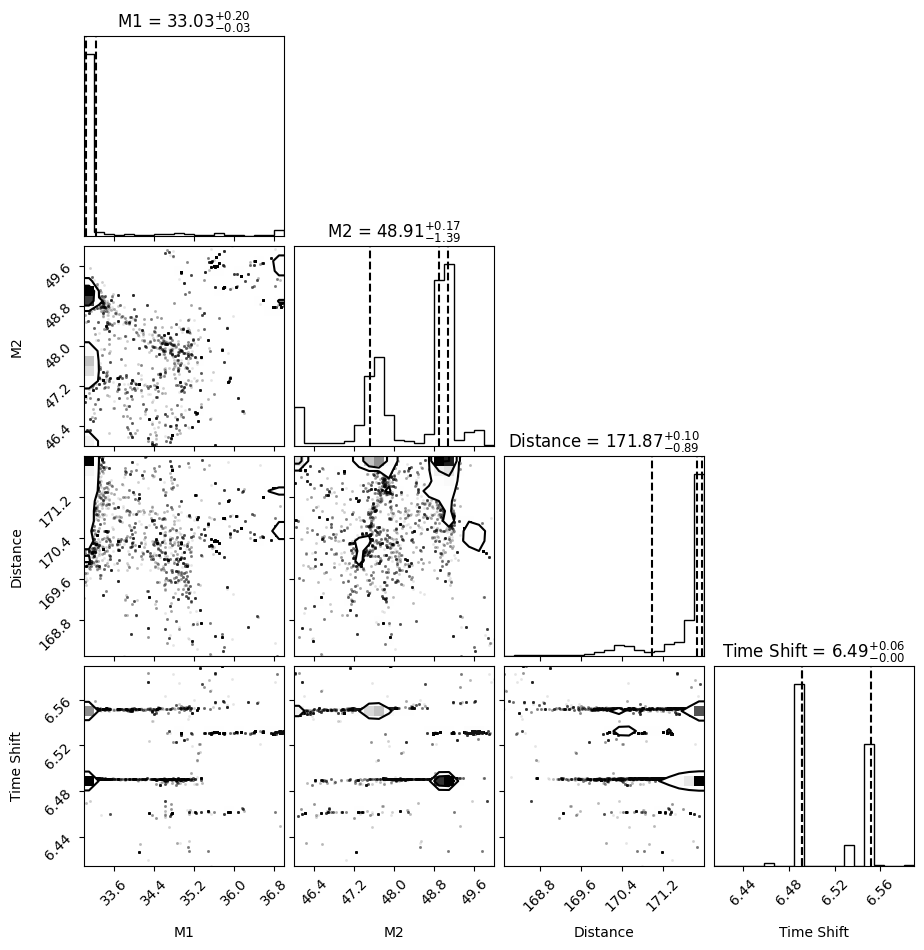

In [14]:
# this is with delta_t mulitpled to signal
samples = sampler.flatchain

figure = corner.corner(samples,labels = ['M1','M2','Distance','Time Shift'],quantiles=[0.16,0.5,0.84],show_titles = True)

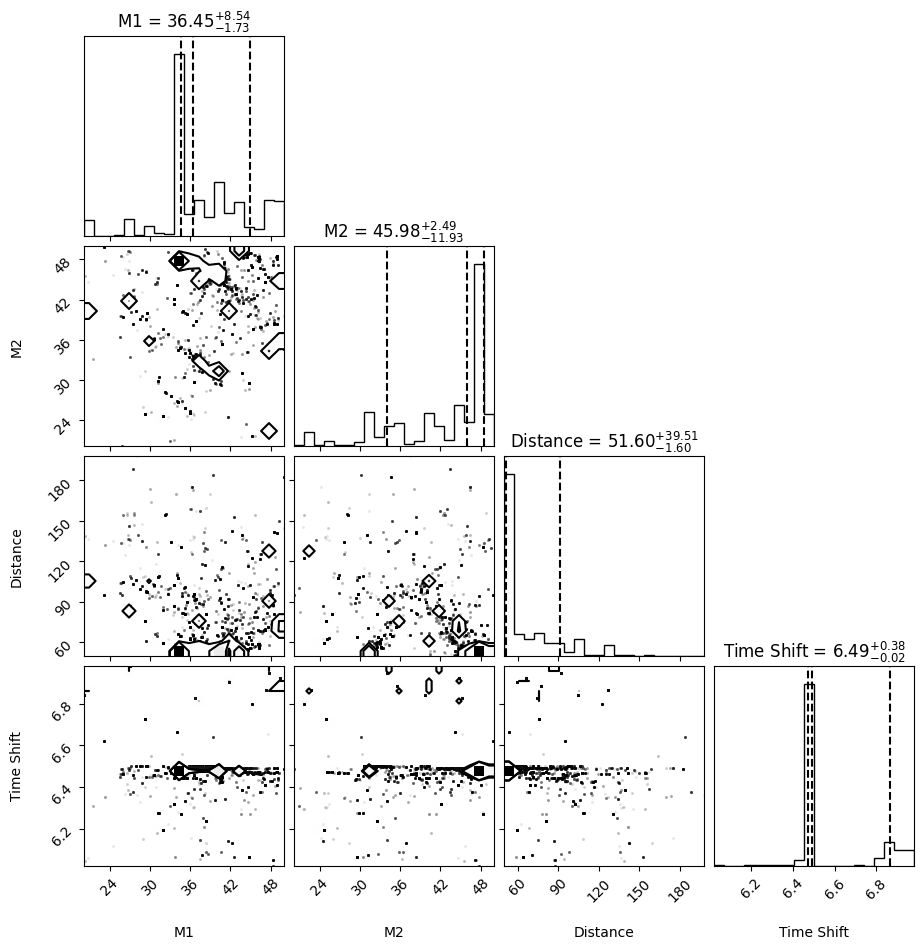

In [ ]:
samples = sampler.flatchain

figure = corner.corner(samples,labels = ['M1','M2','Distance','Time Shift'],quantiles=[0.16,0.5,0.84],show_titles = True)

# figure.savefig("corner_plot_unknown_M1_M2_D_time_largeprior.jpg", format="jpeg", dpi=300)

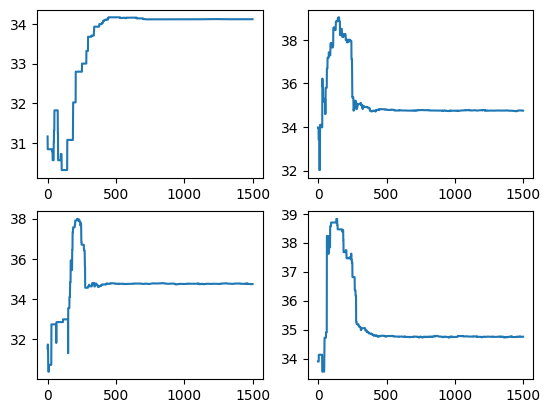

In [53]:
samples = sampler.get_chain()


plt.subplot(221)
plt.plot(samples[:,4,0])
plt.subplot(222)
plt.plot(samples[:,3,0])
plt.subplot(223)
plt.plot(samples[:,2,0])
plt.subplot(224)
plt.plot(samples[:,1,0])

# plotting the mcmc results

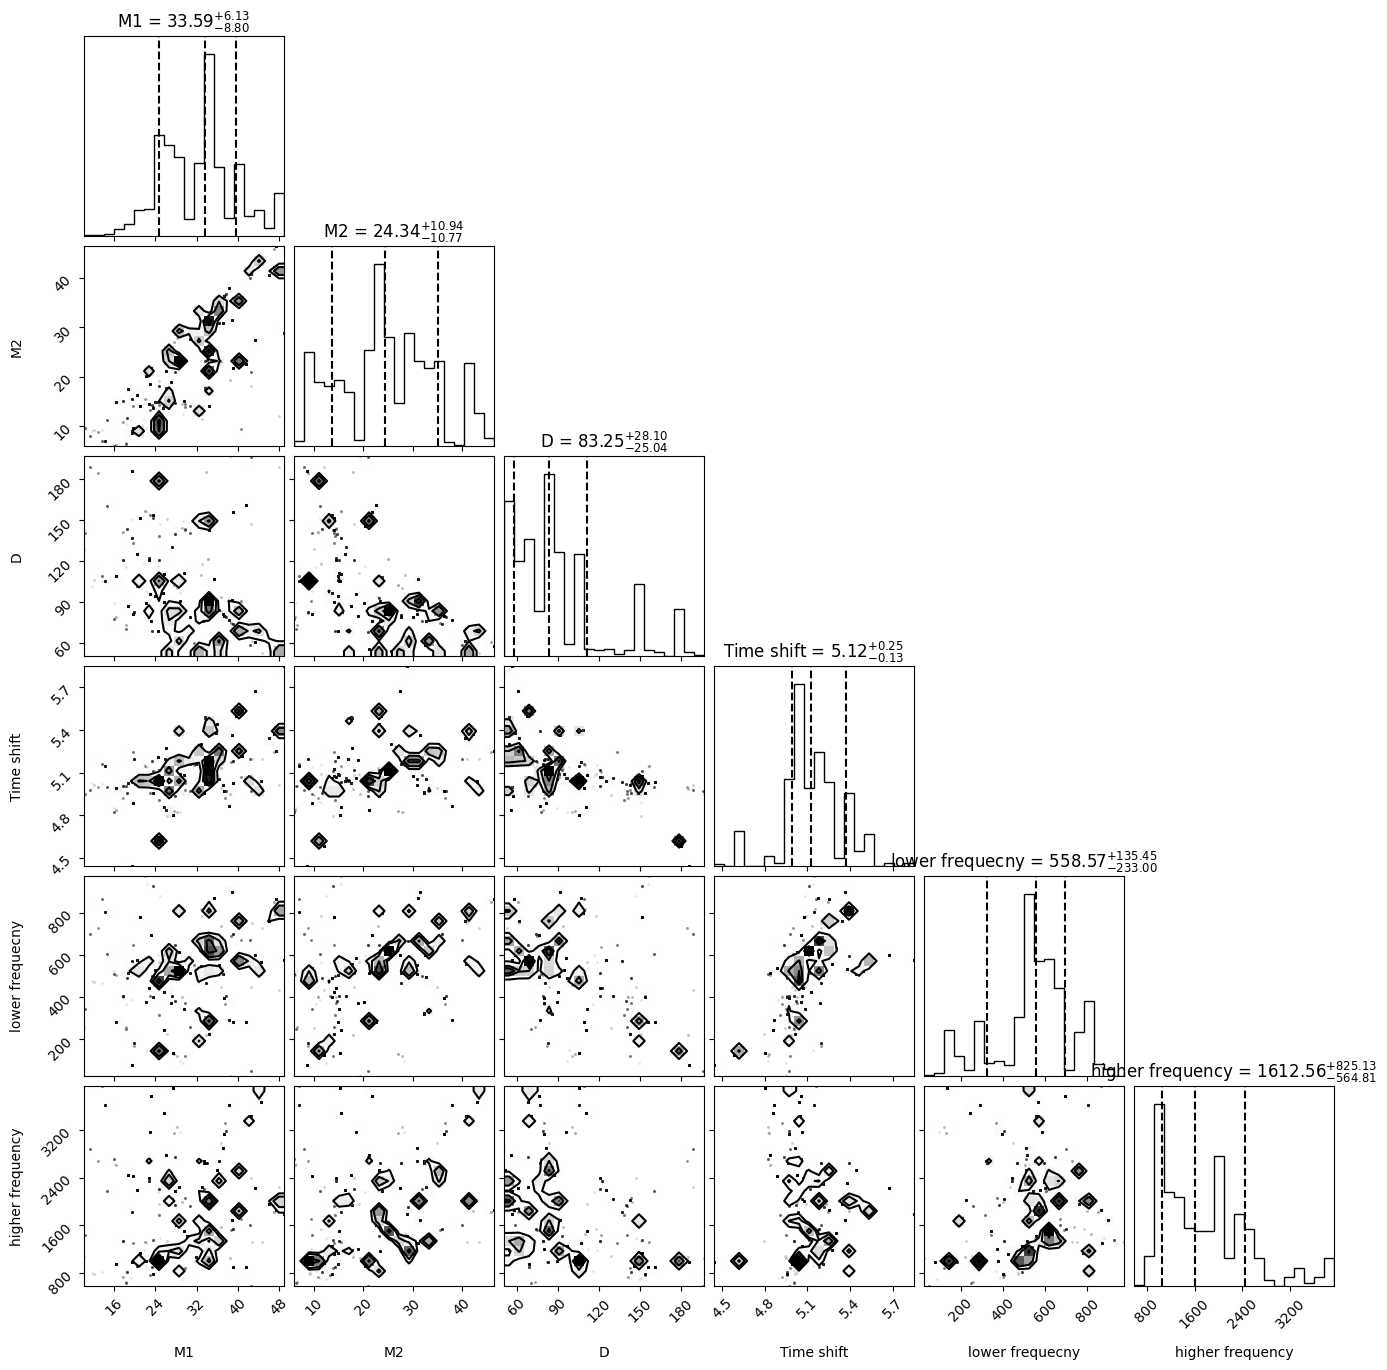

In [114]:
# this was 10 walkers, 1500 burn in, and 500 steps
samples = sampler.flatchain
# samples = sampler.get_chain(flat=True)
# samples = sampler.get_chain()


figure = corner.corner(samples,labels = ['M1','M2','D','Time shift','lower frequecny','higher frequency'],quantiles=[0.16,0.5,0.84],show_titles = True)

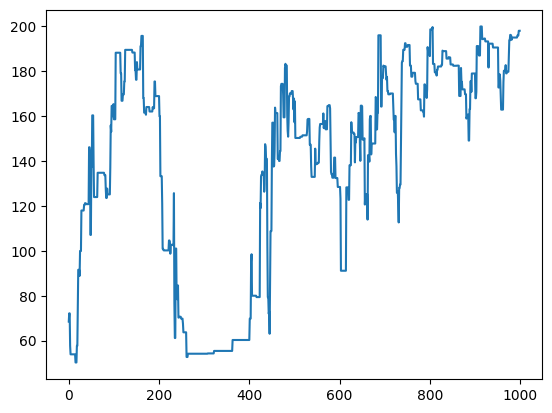

In [24]:
samples = sampler.get_chain()

plt.plot(samples[:,5,2])